In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# DataLoader Arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Select Dataset and define Transform
transform = transforms.Compose([transforms.Resize((10, 10)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2) | (mnist_train.targets == 3) 
mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
indices = (mnist_test.targets == 0) | (mnist_test.targets == 1) | (mnist_test.targets == 2) | (mnist_test.targets == 3) 
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

print(f"The size of train_set is {len(mnist_train)}")    # 24754
print(f"The size of test_set is {len(mnist_test)}")      # 4157

# Create DataLoaders, load multiple samples up into memory in batches
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

The size of train_set is 24754
The size of test_set is 4157


In [4]:
# Network Architecture
num_inputs = 10*10  
num_hidden = 200
num_outputs = 4   # 4 outputs classes: 0, 1, 2, 3

# Temporal Dynamics
num_steps = 10      # run for 10 time steps
beta = 0.95 

# Define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        # Neuron input: Spik_in W x X[t] and U[t-1], Neuron output: Spike S[t] and U[t]
        self.lif1 = snn.Leaky(beta=beta, threshold=0.001)  # Threshold=0.001: each raw image pixel value greater than 0 corresponds to a spike
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, threshold=0.1)  
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, threshold=0.7)
        
    def forward(self, x):
        
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        # Record the finial laye
#         spk1_rec = []
#         mem1_rec = []
#         spk2_rec = []
#         mem2_rec = []
        spk3_rec = []
        mem3_rec = []
        
        for step in range(num_steps):
            spk1, mem1 = self.lif1(x, mem1)            # analog signal --> spike X[t]
            cur1 = self.fc1(spk1)                   # X[t] x weight --> post-synaptic current
            spk2, mem2 = self.lif2(cur1, mem2)   # post-syn current + decayed membrane --> mem[t+1]
            cur2 = self.fc2(spk2)
            spk3, mem3 = self.lif2(cur2, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
        
        # Convert lists to tensors: Concatenates a sequence of tensors along a new dimension(time).
        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
    
net = Net()

In [5]:
# pass data into the network, sum the spikes_output over time and compare the neuron with the highest number of spikes with the target
def print_batch_accuracy(data, targets, train=True):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)                       # max(1):return the max value and indices of each row
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for single nminibatch: {acc*100: .2f}%")
    else:
        print(f"Test set accuracy for single nminibatch: {acc*100: .2f}%")
    return acc*100

def loss_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {train_loss_hist[counter]: .2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]: .2f}")
    
loss = nn.CrossEntropyLoss()   # Loss definition

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))  # Optimizer

In [6]:
# Training loop
num_epochs = 100
train_loss_hist = []
test_loss_hist = []
test_acc_hist = []

counter = 0
best_acc = 0

# Outer training loop
for epoch in range(num_epochs):
    
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:   # Or"for batch_idx, (data, targets) in enumerate(train_loader):"
        # forward pass
        net.train()      # Training mode
        spk_rec, mem_rec = net(data.view(batch_size, -1))   # Flatten the input data to a vector of size 100 and pass it into the network.
                                                           # output mem_shape: [10, 128, 4]
        
        # Initialize the loss and sum over time
        train_loss = torch.zeros((1), dtype=dtype)
        for step in range(num_steps):
            train_loss += loss(mem_rec[step], targets)      # Cross-entropy between Pi and the target Yi([0, 1], one-hot target)
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Store train_loss history for future plotting
        train_loss_hist.append(train_loss.item())      # extract element_val and precision is higher
        
        # Test set
        with torch.no_grad():
            net.eval()          # Test mode
            test_data, test_targets = next(iter(test_loader))
            
            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))
            
            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            
            test_loss_hist.append(test_loss.item())
            
            # print train/test loss/accuracy
            if counter % 10 == 0:            # iteratively print out every 10 iterations
                loss_printer()
                train_acc = print_batch_accuracy(data, targets, train=True)
                test_acc = print_batch_accuracy(test_data, test_targets, train=False)
                test_acc_hist.append(test_acc.item())
                print(test_acc)
                print("\n")
                # Store best accuracy
                if test_acc > best_acc:
                    torch.save(net.state_dict(), 'new5_model.pt')
                    best_acc = test_acc
            counter += 1
            iter_counter += 1

Epoch 0, Iteration 0
Train Set Loss:  24.82
Test Set Loss:  21.04
Train set accuracy for single nminibatch:  21.09%
Test set accuracy for single nminibatch:  20.31%
20.3125


Epoch 0, Iteration 10
Train Set Loss:  11.50
Test Set Loss:  10.77
Train set accuracy for single nminibatch:  45.31%
Test set accuracy for single nminibatch:  56.25%
56.25


Epoch 0, Iteration 20
Train Set Loss:  7.75
Test Set Loss:  8.40
Train set accuracy for single nminibatch:  67.19%
Test set accuracy for single nminibatch:  60.94%
60.9375


Epoch 0, Iteration 30
Train Set Loss:  7.38
Test Set Loss:  7.53
Train set accuracy for single nminibatch:  67.97%
Test set accuracy for single nminibatch:  64.84%
64.84375


Epoch 0, Iteration 40
Train Set Loss:  7.02
Test Set Loss:  7.06
Train set accuracy for single nminibatch:  75.78%
Test set accuracy for single nminibatch:  75.78%
75.78125


Epoch 0, Iteration 50
Train Set Loss:  6.10
Test Set Loss:  5.82
Train set accuracy for single nminibatch:  79.69%
Test set acc

Epoch 2, Iteration 84
Train Set Loss:  3.59
Test Set Loss:  3.21
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 2, Iteration 94
Train Set Loss:  2.67
Test Set Loss:  2.56
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 2, Iteration 104
Train Set Loss:  2.37
Test Set Loss:  3.82
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 2, Iteration 114
Train Set Loss:  3.90
Test Set Loss:  3.17
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 2, Iteration 124
Train Set Loss:  3.75
Test Set Loss:  2.26
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 2, Iteration 134
Train Set Loss:  2.78
Test Set Loss:  3.00
Train set accuracy for single nminibatch:  83.59%
Test set 

Epoch 4, Iteration 168
Train Set Loss:  2.69
Test Set Loss:  2.05
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 4, Iteration 178
Train Set Loss:  2.66
Test Set Loss:  2.74
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 4, Iteration 188
Train Set Loss:  2.93
Test Set Loss:  2.38
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  85.94%
85.9375


Epoch 5, Iteration 5
Train Set Loss:  2.63
Test Set Loss:  2.27
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 5, Iteration 15
Train Set Loss:  2.56
Test Set Loss:  1.79
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 5, Iteration 25
Train Set Loss:  2.20
Test Set Loss:  2.51
Train set accuracy for single nminibatch:  94.53%
Test set ac

Epoch 7, Iteration 59
Train Set Loss:  2.99
Test Set Loss:  2.71
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 7, Iteration 69
Train Set Loss:  2.29
Test Set Loss:  2.44
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 7, Iteration 79
Train Set Loss:  2.23
Test Set Loss:  2.86
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 7, Iteration 89
Train Set Loss:  2.27
Test Set Loss:  2.98
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 7, Iteration 99
Train Set Loss:  1.95
Test Set Loss:  2.05
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 7, Iteration 109
Train Set Loss:  1.46
Test Set Loss:  3.26
Train set accuracy for single nminibatch:  94.53%
Test set accura

Epoch 9, Iteration 143
Train Set Loss:  2.14
Test Set Loss:  1.99
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 9, Iteration 153
Train Set Loss:  1.61
Test Set Loss:  2.44
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 9, Iteration 163
Train Set Loss:  1.66
Test Set Loss:  2.07
Train set accuracy for single nminibatch:  84.38%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 9, Iteration 173
Train Set Loss:  2.65
Test Set Loss:  2.27
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 9, Iteration 183
Train Set Loss:  1.52
Test Set Loss:  2.50
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 10, Iteration 0
Train Set Loss:  2.09
Test Set Loss:  2.98
Train set accuracy for single nminibatch:  92.19%
Test set ac

Epoch 12, Iteration 34
Train Set Loss:  2.74
Test Set Loss:  3.68
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  84.38%
84.375


Epoch 12, Iteration 44
Train Set Loss:  2.32
Test Set Loss:  1.94
Train set accuracy for single nminibatch:  84.38%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 12, Iteration 54
Train Set Loss:  1.15
Test Set Loss:  1.72
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 12, Iteration 64
Train Set Loss:  2.36
Test Set Loss:  1.20
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  96.88%
96.875


Epoch 12, Iteration 74
Train Set Loss:  1.35
Test Set Loss:  1.16
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 12, Iteration 84
Train Set Loss:  1.16
Test Set Loss:  1.56
Train set accuracy for single nminibatch:  95.31%
Test set

Epoch 14, Iteration 118
Train Set Loss:  1.12
Test Set Loss:  1.91
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 14, Iteration 128
Train Set Loss:  2.96
Test Set Loss:  1.16
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  94.53%
94.53125


Epoch 14, Iteration 138
Train Set Loss:  1.84
Test Set Loss:  1.63
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  94.53%
94.53125


Epoch 14, Iteration 148
Train Set Loss:  1.50
Test Set Loss:  1.11
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 14, Iteration 158
Train Set Loss:  1.47
Test Set Loss:  1.82
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  95.31%
95.3125


Epoch 14, Iteration 168
Train Set Loss:  1.10
Test Set Loss:  3.21
Train set accuracy for single nminibatch:  92.97%

Epoch 17, Iteration 9
Train Set Loss:  1.45
Test Set Loss:  2.07
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 17, Iteration 19
Train Set Loss:  2.13
Test Set Loss:  1.92
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 17, Iteration 29
Train Set Loss:  1.39
Test Set Loss:  2.59
Train set accuracy for single nminibatch:  89.06%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 17, Iteration 39
Train Set Loss:  1.49
Test Set Loss:  1.84
Train set accuracy for single nminibatch:  89.06%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 17, Iteration 49
Train Set Loss:  1.64
Test Set Loss:  3.07
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 17, Iteration 59
Train Set Loss:  3.08
Test Set Loss:  0.99
Train set accuracy for single nminibatch:  90.62%
Test set

Epoch 19, Iteration 93
Train Set Loss:  1.65
Test Set Loss:  2.28
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 19, Iteration 103
Train Set Loss:  1.08
Test Set Loss:  2.02
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 19, Iteration 113
Train Set Loss:  1.36
Test Set Loss:  1.34
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 19, Iteration 123
Train Set Loss:  1.60
Test Set Loss:  1.75
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 19, Iteration 133
Train Set Loss:  1.27
Test Set Loss:  2.86
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 19, Iteration 143
Train Set Loss:  2.14
Test Set Loss:  2.26
Train set accuracy for single nminibatch:  89.06%
Test s

Epoch 21, Iteration 177
Train Set Loss:  0.94
Test Set Loss:  2.65
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 21, Iteration 187
Train Set Loss:  1.19
Test Set Loss:  1.89
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 22, Iteration 4
Train Set Loss:  1.07
Test Set Loss:  3.18
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 22, Iteration 14
Train Set Loss:  1.82
Test Set Loss:  2.46
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  85.94%
85.9375


Epoch 22, Iteration 24
Train Set Loss:  1.56
Test Set Loss:  2.20
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 22, Iteration 34
Train Set Loss:  1.12
Test Set Loss:  1.12
Train set accuracy for single nminibatch:  93.75%
Test set

Epoch 24, Iteration 68
Train Set Loss:  1.19
Test Set Loss:  2.09
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 24, Iteration 78
Train Set Loss:  0.85
Test Set Loss:  1.74
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 24, Iteration 88
Train Set Loss:  1.24
Test Set Loss:  2.01
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 24, Iteration 98
Train Set Loss:  1.02
Test Set Loss:  2.08
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 24, Iteration 108
Train Set Loss:  1.02
Test Set Loss:  1.65
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 24, Iteration 118
Train Set Loss:  1.73
Test Set Loss:  2.03
Train set accuracy for single nminibatch:  91.41%
Te

Epoch 26, Iteration 152
Train Set Loss:  1.09
Test Set Loss:  1.21
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 26, Iteration 162
Train Set Loss:  1.46
Test Set Loss:  2.99
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 26, Iteration 172
Train Set Loss:  1.49
Test Set Loss:  1.06
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 26, Iteration 182
Train Set Loss:  1.21
Test Set Loss:  1.53
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 26, Iteration 192
Train Set Loss:  1.41
Test Set Loss:  1.92
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 27, Iteration 9
Train Set Loss:  1.99
Test Set Loss:  1.56
Train set accuracy for single nminibatch:  91.41%
T

Epoch 29, Iteration 43
Train Set Loss:  1.47
Test Set Loss:  1.59
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  85.94%
85.9375


Epoch 29, Iteration 53
Train Set Loss:  1.40
Test Set Loss:  2.27
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 29, Iteration 63
Train Set Loss:  1.61
Test Set Loss:  3.51
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  85.94%
85.9375


Epoch 29, Iteration 73
Train Set Loss:  1.10
Test Set Loss:  2.64
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 29, Iteration 83
Train Set Loss:  0.97
Test Set Loss:  1.68
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 29, Iteration 93
Train Set Loss:  1.29
Test Set Loss:  1.63
Train set accuracy for single nminibatch:  89.84%
Test se

Epoch 31, Iteration 127
Train Set Loss:  2.02
Test Set Loss:  0.60
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  97.66%
97.65625


Epoch 31, Iteration 137
Train Set Loss:  1.57
Test Set Loss:  1.35
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 31, Iteration 147
Train Set Loss:  1.64
Test Set Loss:  2.42
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 31, Iteration 157
Train Set Loss:  1.00
Test Set Loss:  1.59
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  94.53%
94.53125


Epoch 31, Iteration 167
Train Set Loss:  2.01
Test Set Loss:  1.96
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 31, Iteration 177
Train Set Loss:  1.60
Test Set Loss:  1.33
Train set accuracy for single nminibatch:  92.97%
Test se

Epoch 34, Iteration 18
Train Set Loss:  1.89
Test Set Loss:  1.94
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 34, Iteration 28
Train Set Loss:  1.23
Test Set Loss:  1.39
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 34, Iteration 38
Train Set Loss:  1.15
Test Set Loss:  1.40
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 34, Iteration 48
Train Set Loss:  1.29
Test Set Loss:  1.58
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 34, Iteration 58
Train Set Loss:  1.45
Test Set Loss:  2.67
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 34, Iteration 68
Train Set Loss:  1.41
Test Set Loss:  1.94
Train set accuracy for single nminibatch:  90.62%
Test se

Epoch 36, Iteration 102
Train Set Loss:  0.92
Test Set Loss:  1.78
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 36, Iteration 112
Train Set Loss:  1.36
Test Set Loss:  0.59
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  95.31%
95.3125


Epoch 36, Iteration 122
Train Set Loss:  1.46
Test Set Loss:  2.36
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 36, Iteration 132
Train Set Loss:  1.24
Test Set Loss:  2.36
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 36, Iteration 142
Train Set Loss:  0.70
Test Set Loss:  2.89
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 36, Iteration 152
Train Set Loss:  1.10
Test Set Loss:  2.05
Train set accuracy for single nminibatch:  93.75%
Test se

Epoch 38, Iteration 186
Train Set Loss:  2.23
Test Set Loss:  2.56
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 39, Iteration 3
Train Set Loss:  1.59
Test Set Loss:  1.31
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 39, Iteration 13
Train Set Loss:  0.92
Test Set Loss:  2.05
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 39, Iteration 23
Train Set Loss:  1.12
Test Set Loss:  0.87
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 39, Iteration 33
Train Set Loss:  1.29
Test Set Loss:  4.31
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 39, Iteration 43
Train Set Loss:  1.02
Test Set Loss:  1.98
Train set accuracy for single nminibatch:  91.41%
Test set ac

Epoch 41, Iteration 77
Train Set Loss:  0.72
Test Set Loss:  1.13
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 41, Iteration 87
Train Set Loss:  0.86
Test Set Loss:  2.59
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 41, Iteration 97
Train Set Loss:  1.04
Test Set Loss:  2.72
Train set accuracy for single nminibatch:  87.50%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 41, Iteration 107
Train Set Loss:  1.36
Test Set Loss:  1.73
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 41, Iteration 117
Train Set Loss:  1.25
Test Set Loss:  3.85
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 41, Iteration 127
Train Set Loss:  0.84
Test Set Loss:  1.71
Train set accuracy for single nminibatch:  90.62%
Test set

Epoch 43, Iteration 161
Train Set Loss:  1.23
Test Set Loss:  2.46
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 43, Iteration 171
Train Set Loss:  0.90
Test Set Loss:  2.60
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 43, Iteration 181
Train Set Loss:  1.12
Test Set Loss:  3.18
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 43, Iteration 191
Train Set Loss:  1.03
Test Set Loss:  1.10
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 44, Iteration 8
Train Set Loss:  0.67
Test Set Loss:  2.59
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 44, Iteration 18
Train Set Loss:  1.39
Test Set Loss:  1.75
Train set accuracy for single nminibatch:  89.06%
Test set 

Epoch 46, Iteration 52
Train Set Loss:  1.41
Test Set Loss:  3.33
Train set accuracy for single nminibatch:  89.06%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 46, Iteration 62
Train Set Loss:  1.42
Test Set Loss:  3.07
Train set accuracy for single nminibatch:  89.06%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 46, Iteration 72
Train Set Loss:  0.61
Test Set Loss:  1.98
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 46, Iteration 82
Train Set Loss:  1.05
Test Set Loss:  1.91
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 46, Iteration 92
Train Set Loss:  0.73
Test Set Loss:  3.28
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 46, Iteration 102
Train Set Loss:  1.10
Test Set Loss:  3.25
Train set accuracy for single nminibatch:  92.97%
Test set acc

Epoch 48, Iteration 136
Train Set Loss:  1.06
Test Set Loss:  2.51
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 48, Iteration 146
Train Set Loss:  1.24
Test Set Loss:  2.37
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 48, Iteration 156
Train Set Loss:  1.44
Test Set Loss:  1.95
Train set accuracy for single nminibatch:  89.06%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 48, Iteration 166
Train Set Loss:  0.79
Test Set Loss:  1.68
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 48, Iteration 176
Train Set Loss:  1.15
Test Set Loss:  1.31
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 48, Iteration 186
Train Set Loss:  1.36
Test Set Loss:  1.55
Train set accuracy for single nminibatch:  93.75%
Test s

Epoch 51, Iteration 27
Train Set Loss:  0.99
Test Set Loss:  2.54
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 51, Iteration 37
Train Set Loss:  1.36
Test Set Loss:  3.30
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 51, Iteration 47
Train Set Loss:  1.08
Test Set Loss:  3.45
Train set accuracy for single nminibatch:  89.06%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 51, Iteration 57
Train Set Loss:  0.90
Test Set Loss:  1.48
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 51, Iteration 67
Train Set Loss:  0.62
Test Set Loss:  3.21
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 51, Iteration 77
Train Set Loss:  0.67
Test Set Loss:  1.97
Train set accuracy for single nminibatch:  95.31%
Test set

Epoch 53, Iteration 111
Train Set Loss:  0.71
Test Set Loss:  1.26
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  94.53%
94.53125


Epoch 53, Iteration 121
Train Set Loss:  0.92
Test Set Loss:  2.96
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 53, Iteration 131
Train Set Loss:  0.88
Test Set Loss:  2.99
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 53, Iteration 141
Train Set Loss:  1.08
Test Set Loss:  2.37
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 53, Iteration 151
Train Set Loss:  0.92
Test Set Loss:  2.74
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 53, Iteration 161
Train Set Loss:  0.82
Test Set Loss:  2.58
Train set accuracy for single nminibatch:  96.09%
Te

Epoch 56, Iteration 2
Train Set Loss:  0.91
Test Set Loss:  3.27
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 56, Iteration 12
Train Set Loss:  1.11
Test Set Loss:  1.25
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 56, Iteration 22
Train Set Loss:  1.97
Test Set Loss:  3.14
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 56, Iteration 32
Train Set Loss:  1.87
Test Set Loss:  1.49
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 56, Iteration 42
Train Set Loss:  0.89
Test Set Loss:  1.18
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 56, Iteration 52
Train Set Loss:  1.54
Test Set Loss:  1.60
Train set accuracy for single nminibatch:  90.62%
Test s

Epoch 58, Iteration 86
Train Set Loss:  0.87
Test Set Loss:  3.69
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 58, Iteration 96
Train Set Loss:  1.26
Test Set Loss:  2.65
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 58, Iteration 106
Train Set Loss:  1.80
Test Set Loss:  2.00
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 58, Iteration 116
Train Set Loss:  1.08
Test Set Loss:  2.70
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 58, Iteration 126
Train Set Loss:  0.74
Test Set Loss:  1.95
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 58, Iteration 136
Train Set Loss:  1.42
Test Set Loss:  3.15
Train set accuracy for single nminibatch:  93.75%
Test se

Epoch 60, Iteration 170
Train Set Loss:  0.87
Test Set Loss:  3.87
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 60, Iteration 180
Train Set Loss:  1.67
Test Set Loss:  2.09
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 60, Iteration 190
Train Set Loss:  0.88
Test Set Loss:  1.31
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 61, Iteration 7
Train Set Loss:  0.81
Test Set Loss:  2.34
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 61, Iteration 17
Train Set Loss:  1.67
Test Set Loss:  3.50
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 61, Iteration 27
Train Set Loss:  0.63
Test Set Loss:  2.66
Train set accuracy for single nminibatch:  95.31%
Test

Epoch 63, Iteration 61
Train Set Loss:  0.70
Test Set Loss:  2.70
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 63, Iteration 71
Train Set Loss:  1.03
Test Set Loss:  2.62
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 63, Iteration 81
Train Set Loss:  1.29
Test Set Loss:  1.93
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 63, Iteration 91
Train Set Loss:  1.67
Test Set Loss:  1.97
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 63, Iteration 101
Train Set Loss:  0.99
Test Set Loss:  1.86
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 63, Iteration 111
Train Set Loss:  1.08
Test Set Loss:  0.86
Train set accuracy for single nminibatch:  92.97%
Test se

Epoch 65, Iteration 145
Train Set Loss:  0.50
Test Set Loss:  5.54
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 65, Iteration 155
Train Set Loss:  1.19
Test Set Loss:  4.14
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 65, Iteration 165
Train Set Loss:  0.96
Test Set Loss:  3.36
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 65, Iteration 175
Train Set Loss:  0.71
Test Set Loss:  3.50
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 65, Iteration 185
Train Set Loss:  0.67
Test Set Loss:  3.68
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  85.94%
85.9375


Epoch 66, Iteration 2
Train Set Loss:  1.59
Test Set Loss:  2.96
Train set accuracy for single nminibatch:  89.84%
Test 

Epoch 68, Iteration 36
Train Set Loss:  0.84
Test Set Loss:  1.32
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 68, Iteration 46
Train Set Loss:  0.47
Test Set Loss:  1.33
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 68, Iteration 56
Train Set Loss:  1.24
Test Set Loss:  3.13
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  82.81%
82.8125


Epoch 68, Iteration 66
Train Set Loss:  1.02
Test Set Loss:  2.49
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 68, Iteration 76
Train Set Loss:  1.19
Test Set Loss:  1.80
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 68, Iteration 86
Train Set Loss:  0.62
Test Set Loss:  2.49
Train set accuracy for single nminibatch:  96.09%
Test se

Epoch 70, Iteration 120
Train Set Loss:  0.78
Test Set Loss:  2.84
Train set accuracy for single nminibatch:  98.44%
Test set accuracy for single nminibatch:  95.31%
95.3125


Epoch 70, Iteration 130
Train Set Loss:  1.45
Test Set Loss:  2.83
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 70, Iteration 140
Train Set Loss:  1.01
Test Set Loss:  2.69
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 70, Iteration 150
Train Set Loss:  1.01
Test Set Loss:  1.97
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 70, Iteration 160
Train Set Loss:  0.93
Test Set Loss:  2.14
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 70, Iteration 170
Train Set Loss:  0.61
Test Set Loss:  4.60
Train set accuracy for single nminibatch:  96.09%
Test s

Epoch 73, Iteration 11
Train Set Loss:  1.73
Test Set Loss:  1.68
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 73, Iteration 21
Train Set Loss:  0.98
Test Set Loss:  2.74
Train set accuracy for single nminibatch:  89.84%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 73, Iteration 31
Train Set Loss:  0.95
Test Set Loss:  3.78
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 73, Iteration 41
Train Set Loss:  0.82
Test Set Loss:  1.13
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 73, Iteration 51
Train Set Loss:  0.68
Test Set Loss:  4.17
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 73, Iteration 61
Train Set Loss:  0.55
Test Set Loss:  1.43
Train set accuracy for single nminibatch:  90.62%
Test s

Epoch 75, Iteration 95
Train Set Loss:  0.51
Test Set Loss:  2.84
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 75, Iteration 105
Train Set Loss:  0.82
Test Set Loss:  2.66
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 75, Iteration 115
Train Set Loss:  0.83
Test Set Loss:  3.76
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  85.16%
85.15625


Epoch 75, Iteration 125
Train Set Loss:  1.08
Test Set Loss:  2.33
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 75, Iteration 135
Train Set Loss:  0.72
Test Set Loss:  2.67
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 75, Iteration 145
Train Set Loss:  0.58
Test Set Loss:  1.68
Train set accuracy for single nminibatch:  95.31%
Test 

Epoch 77, Iteration 179
Train Set Loss:  1.24
Test Set Loss:  2.63
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 77, Iteration 189
Train Set Loss:  0.59
Test Set Loss:  2.66
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 78, Iteration 6
Train Set Loss:  1.06
Test Set Loss:  1.88
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 78, Iteration 16
Train Set Loss:  0.96
Test Set Loss:  2.59
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 78, Iteration 26
Train Set Loss:  0.99
Test Set Loss:  3.96
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 78, Iteration 36
Train Set Loss:  0.72
Test Set Loss:  3.66
Train set accuracy for single nminibatch:  91.41%
Test set a

Epoch 80, Iteration 70
Train Set Loss:  1.52
Test Set Loss:  1.25
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 80, Iteration 80
Train Set Loss:  0.79
Test Set Loss:  5.23
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 80, Iteration 90
Train Set Loss:  0.73
Test Set Loss:  1.21
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 80, Iteration 100
Train Set Loss:  0.89
Test Set Loss:  2.67
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 80, Iteration 110
Train Set Loss:  0.93
Test Set Loss:  3.88
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 80, Iteration 120
Train Set Loss:  1.38
Test Set Loss:  3.39
Train set accuracy for single nminibatch:  93.75%
Test s

Epoch 82, Iteration 154
Train Set Loss:  0.66
Test Set Loss:  3.29
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  96.09%
96.09375


Epoch 82, Iteration 164
Train Set Loss:  1.05
Test Set Loss:  1.81
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 82, Iteration 174
Train Set Loss:  1.04
Test Set Loss:  4.53
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 82, Iteration 184
Train Set Loss:  0.58
Test Set Loss:  3.14
Train set accuracy for single nminibatch:  98.44%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 83, Iteration 1
Train Set Loss:  0.42
Test Set Loss:  2.11
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 83, Iteration 11
Train Set Loss:  0.64
Test Set Loss:  3.06
Train set accuracy for single nminibatch:  94.53%
Te

Epoch 85, Iteration 45
Train Set Loss:  0.99
Test Set Loss:  3.50
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 85, Iteration 55
Train Set Loss:  0.60
Test Set Loss:  1.77
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 85, Iteration 65
Train Set Loss:  0.73
Test Set Loss:  3.21
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  85.94%
85.9375


Epoch 85, Iteration 75
Train Set Loss:  0.94
Test Set Loss:  1.36
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 85, Iteration 85
Train Set Loss:  1.33
Test Set Loss:  1.76
Train set accuracy for single nminibatch:  88.28%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 85, Iteration 95
Train Set Loss:  1.02
Test Set Loss:  2.38
Train set accuracy for single nminibatch:  93.75%
Test set

Epoch 87, Iteration 129
Train Set Loss:  0.50
Test Set Loss:  4.25
Train set accuracy for single nminibatch:  95.31%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 87, Iteration 139
Train Set Loss:  0.41
Test Set Loss:  4.61
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 87, Iteration 149
Train Set Loss:  0.86
Test Set Loss:  3.97
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  88.28%
88.28125


Epoch 87, Iteration 159
Train Set Loss:  0.60
Test Set Loss:  1.16
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 87, Iteration 169
Train Set Loss:  0.64
Test Set Loss:  3.98
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 87, Iteration 179
Train Set Loss:  0.65
Test Set Loss:  3.59
Train set accuracy for single nminibatch:  92.97%

Epoch 90, Iteration 20
Train Set Loss:  0.83
Test Set Loss:  1.80
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  94.53%
94.53125


Epoch 90, Iteration 30
Train Set Loss:  0.79
Test Set Loss:  1.74
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  97.66%
97.65625


Epoch 90, Iteration 40
Train Set Loss:  0.60
Test Set Loss:  3.21
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  85.16%
85.15625


Epoch 90, Iteration 50
Train Set Loss:  0.36
Test Set Loss:  0.90
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 90, Iteration 60
Train Set Loss:  0.51
Test Set Loss:  1.84
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 90, Iteration 70
Train Set Loss:  1.20
Test Set Loss:  2.60
Train set accuracy for single nminibatch:  91.41%
Test set 

Epoch 92, Iteration 104
Train Set Loss:  0.76
Test Set Loss:  2.20
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 92, Iteration 114
Train Set Loss:  0.72
Test Set Loss:  2.51
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 92, Iteration 124
Train Set Loss:  1.35
Test Set Loss:  1.30
Train set accuracy for single nminibatch:  90.62%
Test set accuracy for single nminibatch:  95.31%
95.3125


Epoch 92, Iteration 134
Train Set Loss:  0.99
Test Set Loss:  2.67
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 92, Iteration 144
Train Set Loss:  1.09
Test Set Loss:  6.25
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  87.50%
87.5


Epoch 92, Iteration 154
Train Set Loss:  0.69
Test Set Loss:  3.80
Train set accuracy for single nminibatch:  92.97%
Test s

Epoch 94, Iteration 188
Train Set Loss:  0.42
Test Set Loss:  5.00
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  84.38%
84.375


Epoch 95, Iteration 5
Train Set Loss:  1.00
Test Set Loss:  3.66
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 95, Iteration 15
Train Set Loss:  0.42
Test Set Loss:  1.81
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  86.72%
86.71875


Epoch 95, Iteration 25
Train Set Loss:  0.98
Test Set Loss:  3.12
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  92.97%
92.96875


Epoch 95, Iteration 35
Train Set Loss:  1.29
Test Set Loss:  0.42
Train set accuracy for single nminibatch:  92.19%
Test set accuracy for single nminibatch:  96.88%
96.875


Epoch 95, Iteration 45
Train Set Loss:  1.20
Test Set Loss:  1.10
Train set accuracy for single nminibatch:  90.62%
Test set a

Epoch 97, Iteration 79
Train Set Loss:  0.52
Test Set Loss:  2.48
Train set accuracy for single nminibatch:  93.75%
Test set accuracy for single nminibatch:  92.19%
92.1875


Epoch 97, Iteration 89
Train Set Loss:  0.66
Test Set Loss:  4.01
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 97, Iteration 99
Train Set Loss:  0.51
Test Set Loss:  3.01
Train set accuracy for single nminibatch:  96.88%
Test set accuracy for single nminibatch:  93.75%
93.75


Epoch 97, Iteration 109
Train Set Loss:  0.72
Test Set Loss:  4.42
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  89.84%
89.84375


Epoch 97, Iteration 119
Train Set Loss:  0.66
Test Set Loss:  1.28
Train set accuracy for single nminibatch:  92.97%
Test set accuracy for single nminibatch:  90.62%
90.625


Epoch 97, Iteration 129
Train Set Loss:  1.51
Test Set Loss:  2.54
Train set accuracy for single nminibatch:  93.75%
Test se

Epoch 99, Iteration 163
Train Set Loss:  0.83
Test Set Loss:  2.33
Train set accuracy for single nminibatch:  91.41%
Test set accuracy for single nminibatch:  89.06%
89.0625


Epoch 99, Iteration 173
Train Set Loss:  0.64
Test Set Loss:  1.21
Train set accuracy for single nminibatch:  94.53%
Test set accuracy for single nminibatch:  91.41%
91.40625


Epoch 99, Iteration 183
Train Set Loss:  0.39
Test Set Loss:  2.10
Train set accuracy for single nminibatch:  96.09%
Test set accuracy for single nminibatch:  92.97%
92.96875




In [7]:
print(best_acc)   # Epoch 24, Iteration 168

97.65625


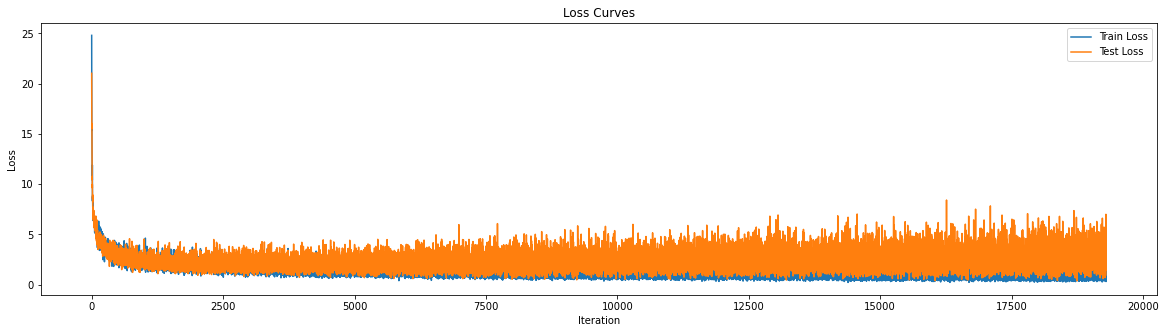

In [8]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

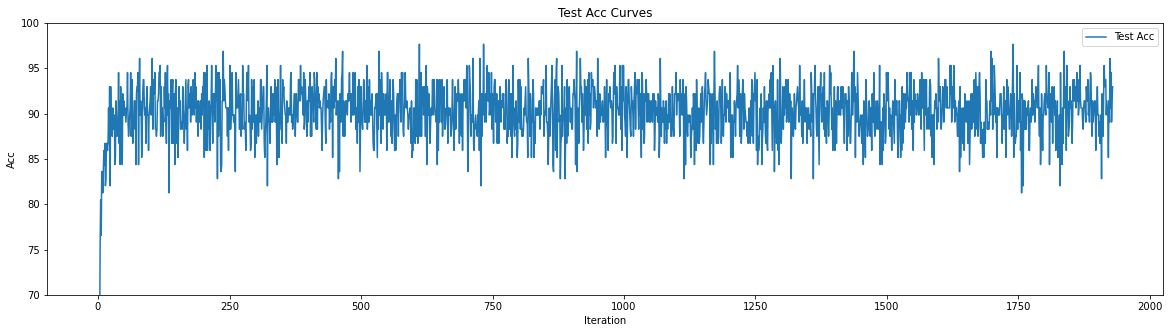

In [9]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.plot(test_acc_hist)
plt.title("Test Acc Curves")
plt.legend(["Test Acc"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.ylim((70, 100))
plt.show()

In [10]:
print(test_acc_hist)

[20.3125, 56.25, 60.9375, 64.84375, 75.78125, 80.46875, 76.5625, 83.59375, 83.59375, 81.25, 83.59375, 85.9375, 84.375, 86.71875, 82.03125, 82.8125, 86.71875, 86.71875, 85.9375, 86.71875, 90.625, 86.71875, 92.96875, 82.03125, 92.96875, 88.28125, 89.0625, 87.5, 90.625, 88.28125, 89.0625, 89.84375, 84.375, 85.15625, 91.40625, 89.84375, 87.5, 89.0625, 89.0625, 94.53125, 86.71875, 91.40625, 84.375, 92.96875, 89.0625, 87.5, 84.375, 92.1875, 89.84375, 91.40625, 89.84375, 90.625, 89.84375, 89.0625, 90.625, 90.625, 94.53125, 89.0625, 87.5, 88.28125, 89.84375, 90.625, 94.53125, 87.5, 89.0625, 93.75, 86.71875, 89.0625, 88.28125, 91.40625, 91.40625, 89.84375, 84.375, 92.1875, 92.96875, 92.96875, 94.53125, 84.375, 92.1875, 96.09375, 89.84375, 91.40625, 89.84375, 85.15625, 88.28125, 92.1875, 93.75, 93.75, 90.625, 89.84375, 90.625, 86.71875, 91.40625, 92.96875, 89.84375, 89.84375, 85.9375, 89.84375, 90.625, 91.40625, 92.96875, 89.84375, 91.40625, 96.09375, 88.28125, 92.1875, 93.75, 92.1875, 94.53125,